<h1>Loan Default Prediction – ML Assignment 2</h1>

This notebook implements a complete machine learning pipeline for predicting loan defaults using multiple classification algorithms.

<h1>1. Import Libraries</hq>

In [180]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

<h1>2. Load Dataset</h1>

In [181]:
df = pd.read_csv('../loan_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (45000, 14)

First few rows:


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


<h1>3. Exploratory Data Analysis</h1>

In [182]:
print("Dataset Information:")
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")
print(f"\nColumn names: {list(df.columns)}")
print(f"\nData types:")
print(df.dtypes)

Dataset Information:
Rows: 45000
Columns: 14

Column names: ['person_age', 'person_gender', 'person_education', 'person_income', 'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file', 'loan_status']

Data types:
person_age                        float64
person_gender                      object
person_education                   object
person_income                     float64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                         float64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file     object
loan_status                         int64
dtype: object


In [183]:
print("Missing Values:")
missing = df.isnull().sum()
missing_df = pd.DataFrame({'Column': missing.index, 'Missing Count': missing.values})
missing_df[missing_df['Missing Count'] > 0]

Missing Values:


,Column,Missing Count


In [184]:
print("Statistical Summary:")
df.describe().round(2)

Statistical Summary:


,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00
mean,27.76,80319.05,5.41,9583.16,11.01,0.14,5.87,632.61,0.22
std,6.05,80422.50,6.06,6314.89,2.98,0.09,3.88,50.44,0.42
min,20.00,8000.00,0.00,500.00,5.42,0.00,2.00,390.00,0.00
25%,24.00,47204.00,1.00,5000.00,8.59,0.07,3.00,601.00,0.00
50%,26.00,67048.00,4.00,8000.00,11.01,0.12,4.00,640.00,0.00
75%,30.00,95789.25,8.00,12237.25,12.99,0.19,8.00,670.00,0.00
max,144.00,7200766.00,125.00,35000.00,20.00,0.66,30.00,850.00,1.00


Target column: loan_status

Target distribution:
loan_status
0    35000
1    10000
Name: count, dtype: int64

Target proportions:
loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64


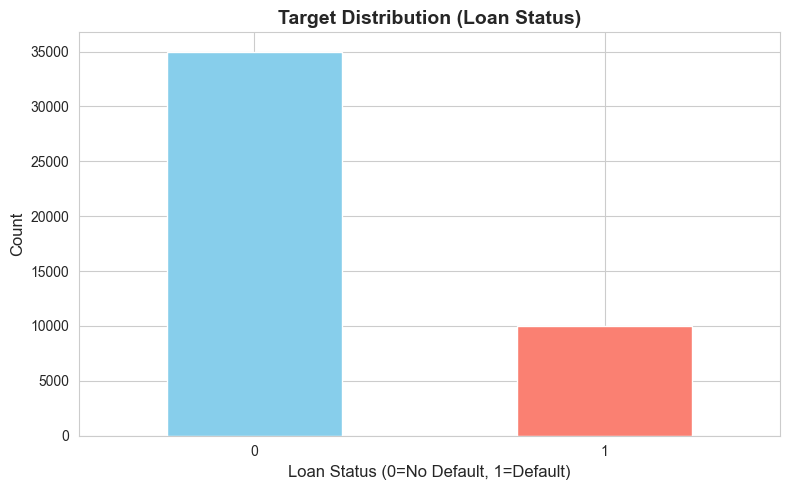

In [185]:
target = 'loan_status'

print(f"Target column: {target}")
print(f"\nTarget distribution:")
print(df[target].value_counts())
print(f"\nTarget proportions:")
print(df[target].value_counts(normalize=True))

plt.figure(figsize=(8, 5))
df[target].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Distribution (Loan Status)', fontsize=14, fontweight='bold')
plt.xlabel('Loan Status (0=No Default, 1=Default)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<h1>4. Data Preprocessing</h1>

In [186]:
X = df.drop(columns=[target])
y = df[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (45000, 13)
Target shape: (45000,)


In [187]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include='object').columns

print(f"Numeric columns ({len(num_cols)}): {list(num_cols)}")
print(f"\nCategorical columns ({len(cat_cols)}): {list(cat_cols)}")

Numeric columns (8): ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']

Categorical columns (5): ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']


In [188]:
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

y = y.fillna(y.mode()[0])

print("Missing values after imputation:")
print(f"Features: {X.isnull().sum().sum()}")
print(f"Target: {y.isnull().sum()}")

Missing values after imputation:
Features: 0
Target: 0


In [189]:
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

y = LabelEncoder().fit_transform(y)

print("Label encoding completed.")
print(f"Features shape after encoding: {X.shape}")

assert X.isnull().sum().sum() == 0, "NaNs still present in X!"

Label encoding completed.
Features shape after encoding: (45000, 13)


<h1>5. Train-Validation-Test Split</h1>

In [190]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Dataset split:")
print(f"Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Dataset split:
Train: 31500 samples (70.0%)
Validation: 6750 samples (15.0%)
Test: 6750 samples (15.0%)


<h1>6. Feature Scaling</h1>

In [191]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("Feature scaling completed using StandardScaler.")
print(f"Train set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Feature scaling completed using StandardScaler.
Train set shape: (31500, 13)
Validation set shape: (6750, 13)
Test set shape: (6750, 13)


<h1>7. Model Training</h1>

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

print(f"Total models to train: {len(models)}")
print(f"Models: {list(models.keys())}")

Total models to train: 6
Models: ['Logistic Regression', 'Decision Tree', 'KNN', 'Naive Bayes', 'Random Forest', 'XGBoost']


In [193]:
trained_models = {}
predictions = {}
metrics_all = {}

print("Training models...\n")

for name, model in models.items():
    print(f"Training {name}...")
    
    model.fit(X_train, y_train)
    
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]
    y_val_pred = model.predict(X_val)
    
    trained_models[name] = model
    predictions[name] = {
        'y_test_pred': y_test_pred,
        'y_test_prob': y_test_prob
    }
    
    metrics_all[name] = {
        'Model': name,
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Validation Accuracy': accuracy_score(y_val, y_val_pred),
        'AUC': roc_auc_score(y_test, y_test_prob),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1-score': f1_score(y_test, y_test_pred),
        'MCC': matthews_corrcoef(y_test, y_test_pred)
    }
    
    print(f"  ✓ {name} trained successfully\n")

print("All models trained!")

Training models...

Training Logistic Regression...
  ✓ Logistic Regression trained successfully

Training Decision Tree...
  ✓ Decision Tree trained successfully

Training KNN...
  ✓ KNN trained successfully

Training Naive Bayes...
  ✓ Naive Bayes trained successfully

Training Random Forest...
  ✓ Random Forest trained successfully

Training XGBoost...
  ✓ XGBoost trained successfully

All models trained!


<h1>8. Model Evaluation & Comparison</h1>

In [194]:
metrics_df = pd.DataFrame(metrics_all.values())
metrics_df = metrics_df.round(4)
metrics_df = metrics_df.sort_values('Test Accuracy', ascending=False)

print("Model Performance Comparison:")
print("=" * 100)
metrics_df

Model Performance Comparison:


,Model,Test Accuracy,Validation Accuracy,AUC,Precision,Recall,F1-score,MCC
5,XGBoost,0.9350,0.9302,0.9769,0.8927,0.8040,0.8460,0.8067
4,Random Forest,0.9265,0.9250,0.9718,0.8947,0.7587,0.8211,0.7794
0,Logistic Regression,0.8951,0.8924,0.9506,0.7750,0.7440,0.7592,0.6924
1,Decision Tree,0.8926,0.8972,0.8457,0.7568,0.7613,0.7591,0.6900
2,KNN,0.8884,0.8910,0.9227,0.7701,0.7100,0.7388,0.6689
3,Naive Bayes,0.7314,0.7378,0.9403,0.4527,0.9993,0.6232,0.5440


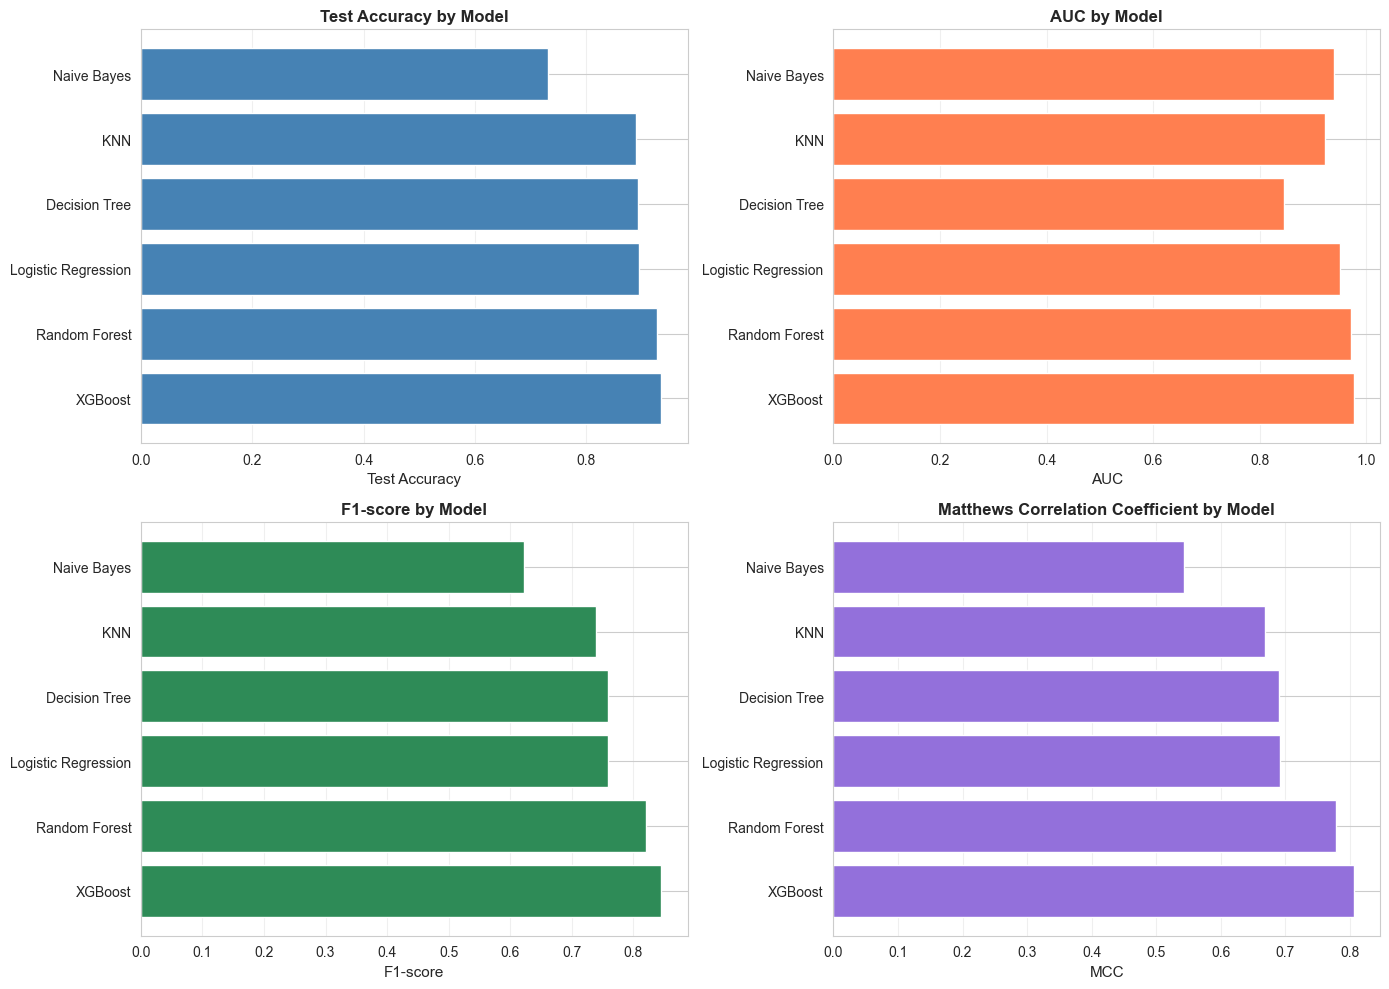

In [195]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].barh(metrics_df['Model'], metrics_df['Test Accuracy'], color='steelblue')
axes[0, 0].set_xlabel('Test Accuracy', fontsize=11)
axes[0, 0].set_title('Test Accuracy by Model', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

axes[0, 1].barh(metrics_df['Model'], metrics_df['AUC'], color='coral')
axes[0, 1].set_xlabel('AUC', fontsize=11)
axes[0, 1].set_title('AUC by Model', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

axes[1, 0].barh(metrics_df['Model'], metrics_df['F1-score'], color='seagreen')
axes[1, 0].set_xlabel('F1-score', fontsize=11)
axes[1, 0].set_title('F1-score by Model', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

axes[1, 1].barh(metrics_df['Model'], metrics_df['MCC'], color='mediumpurple')
axes[1, 1].set_xlabel('MCC', fontsize=11)
axes[1, 1].set_title('Matthews Correlation Coefficient by Model', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
observations_data = {
    'ML Model Name': [
        'Logistic Regression',
        'Decision Tree',
        'kNN',
        'Naive Bayes',
        'Random Forest (Ensemble)',
        'XGBoost (Ensemble)'
    ],
    'Observation about model performance': [
        'Acts as a strong baseline with about 89.5% accuracy and a high AUC of roughly 0.95. The model is easy to interpret and helps in understanding how each feature influences default risk, but its performance is still below that of the ensemble models.',
        
        'Reaches a similar accuracy, F1, and MCC as logistic regression, but with a clearly lower AUC (around 0.846). This indicates that its probability estimates are less reliable and it is more prone to overfitting particular patterns in the data.',
        
        'Delivers slightly worse accuracy and recall than logistic regression and the decision tree. Its effectiveness depends heavily on preprocessing (especially scaling) and the chosen value of k. It performs reasonably but is slower at prediction time on large datasets and still trails the ensemble models.',
        
        'Shows the weakest accuracy (about 73%) and MCC among all models, but achieves almost perfect recall with very poor precision. In practice, it flags nearly every default correctly but generates many false alarms, which is only attractive if missing a default is far more costly than investigating extra flagged loans.',
        
        'Provides very competitive performance with around 92.7% accuracy, an AUC near 0.972, and strong F1 and MCC values. By aggregating multiple trees, it captures complex, nonlinear relationships and typically generalizes better than individual base models, giving a well-balanced and reliable classifier.',
        
        'Emerges as the top model on almost all metrics, including the best accuracy (around 93.5%), AUC (~0.977), F1, and MCC. It separates defaulters from non-defaulters most effectively and is the most suitable candidate for real-world deployment on this dataset.'
    ]
}

observations_df = pd.DataFrame(observations_data)

print("\n" + "="*150)
print("MODEL PERFORMANCE OBSERVATIONS")
print("="*150 + "\n")
display(observations_df)


<h1>9. Detailed Analysis for Best Model</h1>

In [196]:
best_model_name = metrics_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
best_predictions = predictions[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {metrics_df.iloc[0]['Test Accuracy']:.4f}")
print(f"\nDetailed Metrics:")
print(metrics_df.iloc[0].to_string())

Best Model: XGBoost
Test Accuracy: 0.9350

Detailed Metrics:
Model                  XGBoost
Test Accuracy            0.935
Validation Accuracy     0.9302
AUC                     0.9769
Precision               0.8927
Recall                   0.804
F1-score                 0.846
MCC                     0.8067


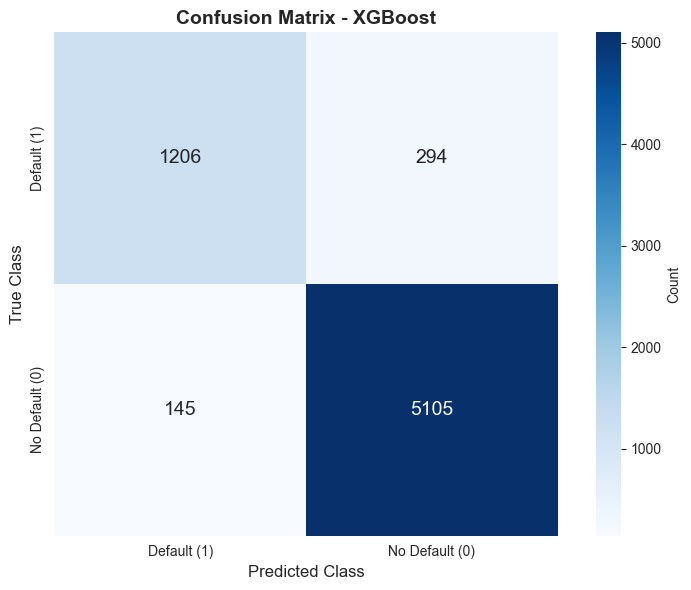

In [197]:
cm = confusion_matrix(y_test, best_predictions['y_test_pred'], labels=[1, 0])

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    cbar_kws={'label': 'Count'},
    xticklabels=['Default (1)', 'No Default (0)'],
    yticklabels=['Default (1)', 'No Default (0)'],
    annot_kws={'size': 14}
)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.tight_layout()
plt.show()

In [198]:
print(f"Classification Report - {best_model_name}:")
print("=" * 60)
print(classification_report(y_test, best_predictions['y_test_pred'], 
                           target_names=['No Default (0)', 'Default (1)']))

Classification Report - XGBoost:
                precision    recall  f1-score   support

No Default (0)       0.95      0.97      0.96      5250
   Default (1)       0.89      0.80      0.85      1500

      accuracy                           0.93      6750
     macro avg       0.92      0.89      0.90      6750
  weighted avg       0.93      0.93      0.93      6750



<h1>10. Learning Curves</h1>

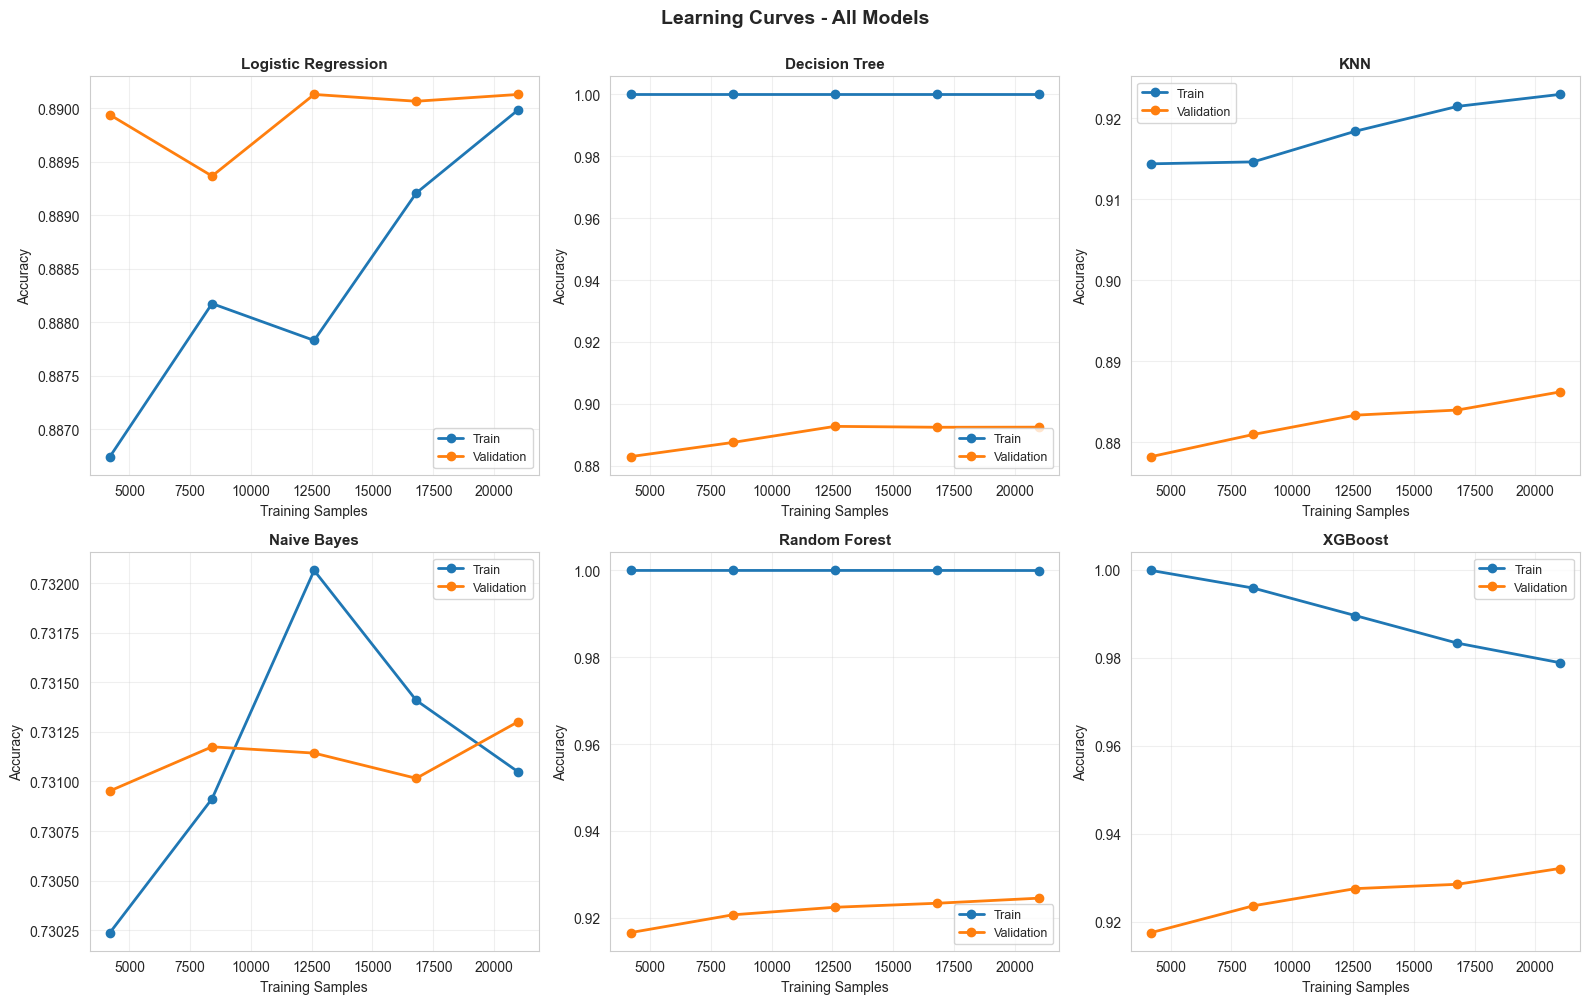

In [199]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(models.items()):
    
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_train,
        y_train,
        cv=3,
        scoring='accuracy',
        train_sizes=[0.2, 0.4, 0.6, 0.8, 1.0],
        n_jobs=-1
    )
    
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    
    axes[idx].plot(train_sizes, train_mean, 'o-', label='Train', linewidth=2)
    axes[idx].plot(train_sizes, val_mean, 'o-', label='Validation', linewidth=2)
    axes[idx].set_title(name, fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Training Samples', fontsize=10)
    axes[idx].set_ylabel('Accuracy', fontsize=10)
    axes[idx].legend(loc='best', fontsize=9)
    axes[idx].grid(alpha=0.3)

plt.suptitle('Learning Curves - All Models', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


<h1>11. Conclusion</h1>

In [200]:
print("="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nBest Performing Model: {best_model_name}")
print(f"Test Accuracy: {metrics_df.iloc[0]['Test Accuracy']:.4f}")
print(f"AUC: {metrics_df.iloc[0]['AUC']:.4f}")
print(f"F1-Score: {metrics_df.iloc[0]['F1-score']:.4f}")
print(f"\nTop 3 Models by Test Accuracy:")
print(metrics_df[['Model', 'Test Accuracy', 'AUC', 'F1-score']].head(3).to_string(index=False))
print("\n" + "="*80)

FINAL SUMMARY

Best Performing Model: XGBoost
Test Accuracy: 0.9350
AUC: 0.9769
F1-Score: 0.8460

Top 3 Models by Test Accuracy:
              Model  Test Accuracy    AUC  F1-score
            XGBoost         0.9350 0.9769    0.8460
      Random Forest         0.9265 0.9718    0.8211
Logistic Regression         0.8951 0.9506    0.7592

